In [1]:
import os
import numpy as np
import torch
from clip_retrieval.clip_client import ClipClient
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import clip

/home/mateusz/anaconda3/envs/pons/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
client = ClipClient(url="https://knn.laion.ai/knn-service", indice_name="laion5B-H-14")

model_name = ['ViT-L/14','RN50x16']

device = 'cuda' if torch.cuda.is_available() else 'cpu'
models = []
preprocesses = []
for model_name in model_name:
    model, preprocess = clip.load(model_name, device=device)
    models.append(model)
    preprocesses.append(preprocess)

In [3]:
items = ['shoe', 'handbag', 'nail polish', 'hat', 't shirt', 'coat','perfume']
brands = ['gucci', 'prada', 'chanel', 'dior', 'versace', 'nike', 'puma',
         'adidas', 'ralph lauren', 'armani', 'dolce & gabbana',
         'max factor', 'loreal', '']
colors = ['red', 'blue', 'green', 'yellow', 'orange', 'purple', 'pink', 'black',
                'white', 'grey', 'brown', 'beige', 'gold', 'silver', 'multicolor']

full_description = [f"{color} {brand} {item}" for item in items for brand in brands for color in colors]

descriptions_tokens = []

descriptions_tokens = clip.tokenize(full_description).to(device)

In [4]:
# Loop over the descriptions and embed them.
text_embeddings = []
n = 2048
for i in range(len(models)):
    with torch.no_grad():
        temp_embeddings = []
        for j in tqdm(range(0, len(descriptions_tokens), n)):
            embeds = models[i].encode_text(descriptions_tokens[j:j+n])
            temp_embeddings.append(embeds)
    text_embeddings.append(torch.cat(temp_embeddings, dim=0))

data_embeddings = torch.stack(text_embeddings)

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


In [5]:
data_embeddings = data_embeddings.to('cuda')

In [6]:
del temp_embeddings, text_embeddings, descriptions_tokens

In [7]:
imgs = os.listdir('temp_imgs')
len(imgs)

8366

In [8]:
img_scores = []
img_tags = []
for i in tqdm(range(len(imgs))):
    img = Image.open(f'temp_imgs/{imgs[i]}')
    #img = preprocesses[0](img).unsqueeze(0).to(device)
    top_3_scores = 0
    tags = []
    for model_i in range(len(models)):
        with torch.no_grad():
            query_tokens = preprocesses[model_i](img).unsqueeze(0).to(device)   
            query_embedding = models[model_i].encode_image(query_tokens)

            similarity = torch.nn.functional.cosine_similarity(data_embeddings[model_i], query_embedding)
            # get the top 3 most simialr data points
            top_10 = torch.topk(similarity, 10).indices
            scores = torch.topk(similarity, 10).values
            tags.append(full_description[top_10[0]])
        top_3_scores += torch.sum(scores[:3]).item()
    img_tags.append(tags)
    img_scores.append(top_3_scores)

100%|██████████| 8366/8366 [07:15<00:00, 19.21it/s]


In [34]:
i = 0
for score in img_scores:
    if score < 1.0:
        i += 1
print(round(i/len(img_scores)*100, 2))

0.57


In [29]:
i = 0
wrong = []
right = []
for j, score in enumerate(img_scores):
    if score < 1.5:
        wrong.append(j)
        i += 1
    else:
        right.append(j)
print(f"{round(i/len(img_scores)*100, 2)}%", i)

53.32% 4461


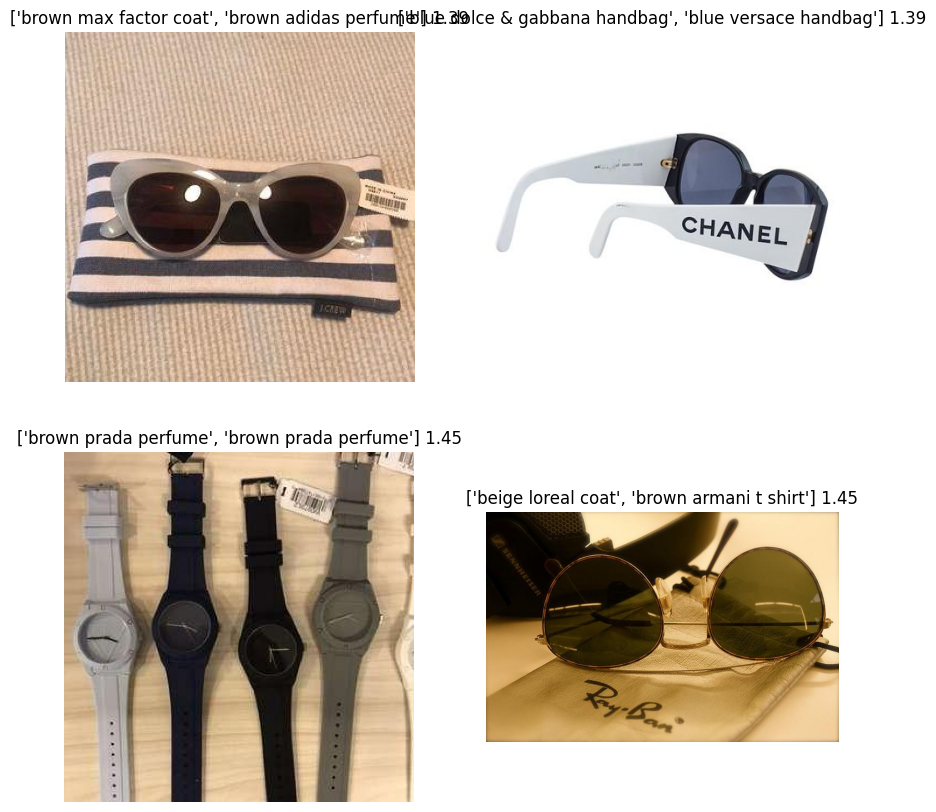

In [28]:
import random

# get 4 random images from the wrong ones and plot them in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    img = Image.open(f'temp_imgs/{imgs[wrong[random.randint(0, len(wrong)-1)]]}')
    ax.imshow(img)
    ax.set_title(f"{img_tags[wrong[i]]} {img_scores[wrong[i]]:.2f}")
    ax.axis('off')
    

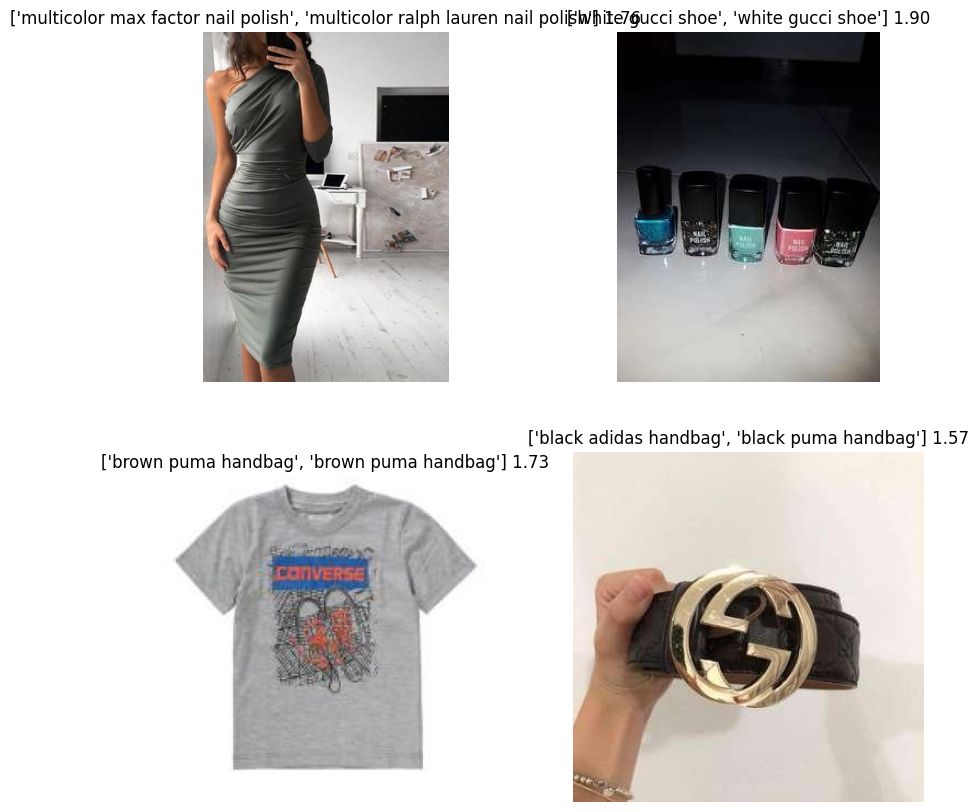

In [38]:
# get 4 random images from the right ones and plot them in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    img = Image.open(f'temp_imgs/{imgs[right[random.randint(0, len(right)-1)]]}')
    ax.imshow(img)
    ax.set_title(f"{img_tags[right[i]]} {img_scores[right[i]]:.2f}")
    ax.axis('off')